# loading libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os 
import glob
import pathlib
import pandas as pd
import numpy as np
import darts
from darts.models.forecasting.arima import ARIMA
from darts import TimeSeries
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import os
import glob
from tqdm import tqdm
from darts.dataprocessing.transformers.scaler import Scaler



# Helping Functions


In [22]:
import numpy as np

def calculate_metrics(actual, predicted):
    # Convert inputs to numpy arrays for easier calculations
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Calculate individual metrics
    mae = np.mean(np.abs(predicted - actual))
    rmse = np.sqrt(np.mean((predicted - actual) ** 2))
    mape = np.mean(np.abs((predicted - actual) / actual)) * 100
    mse = np.mean((predicted - actual) ** 2)
    
    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'MSE': mse
    }
    
    return metrics


# Selected Time Store_Number % family
## Records
* Store Number : 1 & Family : Automative 
* Store Number : 2 & Family :Automative
* Store Number : 3 & Family :Automative
* Store Number : 7 & Family :Automative
* Store Number : 1 & Family : Seafood

In [23]:
fileName = '2_AUTOMOTIVE'
df = pd.read_csv(f'../ProcessedData/GroupData/{fileName}.csv')
df.head()


,date,id,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,...,dcoilwtico,city,state,store_type,cluster,year,month,day_of_month,day_of_week,day_name
0,2013-01-02,2145,2,AUTOMOTIVE,8.0,0,2358,NaN,NaN,NaN,...,93.14,Quito,Pichincha,D,13,2013,1,2,2,Wednesday
1,2013-01-03,3927,2,AUTOMOTIVE,5.0,0,2033,NaN,NaN,NaN,...,92.97,Quito,Pichincha,D,13,2013,1,3,3,Thursday
2,2013-01-04,5709,2,AUTOMOTIVE,3.0,0,2066,NaN,NaN,NaN,...,93.12,Quito,Pichincha,D,13,2013,1,4,4,Friday
3,2013-01-05,7491,2,AUTOMOTIVE,5.0,0,2062,Work Day,National,Ecuador,...,NaN,Quito,Pichincha,D,13,2013,1,5,5,Saturday
4,2013-01-06,9273,2,AUTOMOTIVE,6.0,0,1992,NaN,NaN,NaN,...,NaN,Quito,Pichincha,D,13,2013,1,6,6,Sunday


In [24]:
df = df[['date','sales']]
df = df.drop_duplicates()
df.head()

,date,sales
0,2013-01-02,8.0
1,2013-01-03,5.0
2,2013-01-04,3.0
3,2013-01-05,5.0
4,2013-01-06,6.0


# stationary Tesst

In [25]:
def adfuller_test(values):
    result=adfuller(values)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary ")


ADF Test Statistic : -7.010459174007073
p-value : 6.943453886358411e-10
#Lags Used : 6
Number of Observations Used : 580
P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary


## Spliting Data into Training & Testing Data

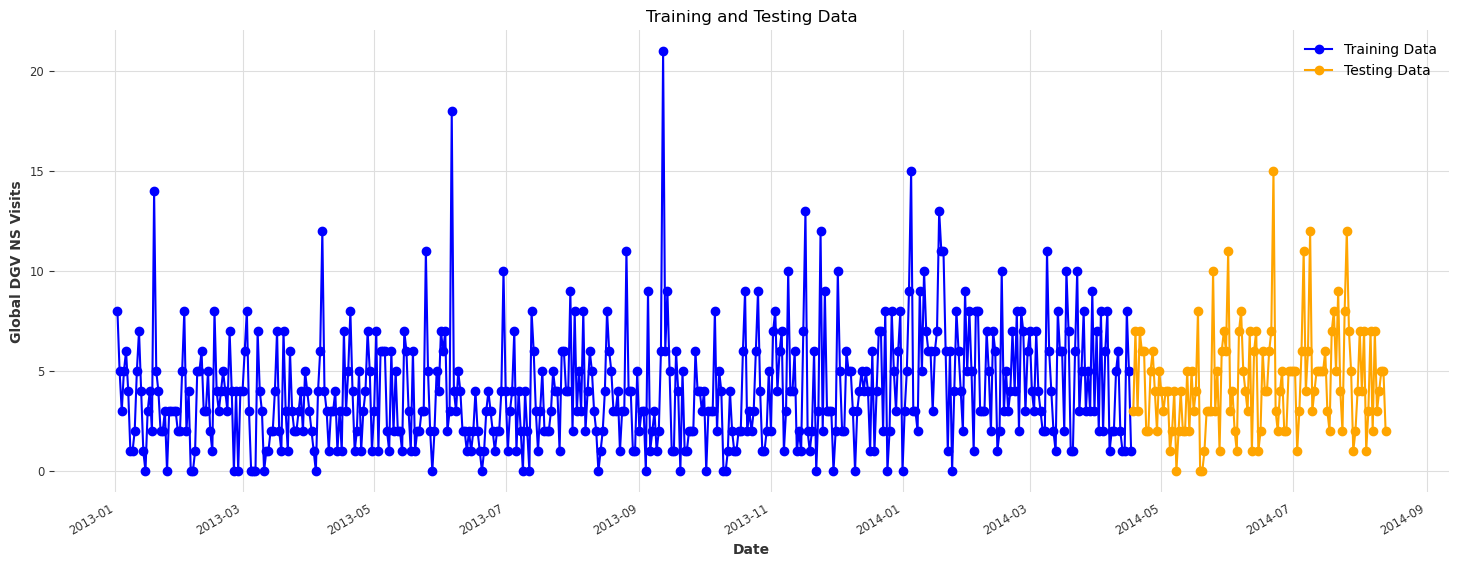

In [27]:
from darts import TimeSeries
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing daily data
series = TimeSeries.from_dataframe(df, "date", "sales", freq='1D', fill_missing_dates=True, fillna_value=0)


split_point = 0.80

train_series, test_series = series.split_after(split_point)

# Set the figure size and style
plt.figure(figsize=(18, 6))
# Plot the training and testing data
train_series.plot(label='Training Data', color='blue', linewidth=1.5, marker='o')
test_series.plot(label='Testing Data', color='orange', linewidth=1.5, marker='o')

# Add title and labels
plt.title('Training and Testing Data')
plt.xlabel('Date')
plt.ylabel('Global DGV NS Visits')

# Add grid lines
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()


## Inspect Seasonality

In [28]:
from darts.utils.statistics import plot_acf, check_seasonality

for m in range(2, 25):
    is_seasonal, period = check_seasonality(train_series, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 9.
There is seasonality of order 12.
There is seasonality of order 14.
There is seasonality of order 21.


## Auto Correlation plot
The autocorrelation function (ACF) is used to identify the order of ARIMA models. The ACF plot shows the correlation between the time series and its lagged version. The lag at which the ACF plot crosses the upper confidence interval for the first time is considered as the order of the **MA** component of the ARIMA model. Similarly, if the ACF plot decays slowly, it indicates that there is a high degree of autocorrelation in the time series, which means that an AR component should be included in the ARIMA model.

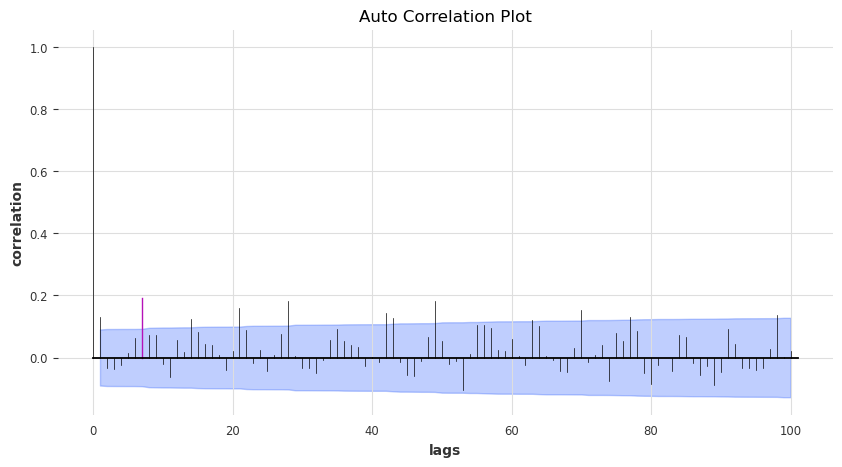

In [29]:
from darts.utils.statistics import plot_acf,plot_pacf


plot_acf(train_series, m=7, max_lag=100,  fig_size=(10, 5), axis=None, default_formatting=True)
plt.xlabel('lags')
plt.ylabel('correlation')
plt.title('Auto Correlation Plot')
plt.show()

## Partial Auto Correlation plot
The partial autocorrelation function (PACF) is also used to identify the order of ARIMA models. The PACF plot shows the correlation between the time series and its lagged version, but with the influence of the intermediate lags removed. The lag at which the PACF plot crosses the upper confidence interval for the first time is considered as the order of the **AR** component of the ARIMA model.

In [ ]:
from darts.utils.statistics import plot_acf,plot_pacf
plot_pacf(train_series, m=7, max_lag=100,  fig_size=(10, 5), axis=None, default_formatting=True)

plt.xlabel('lags')
plt.ylabel('correlation')
plt.title('Partial Auto Correlation Plot')
plt.show()

# Model Fitting

## ARIMA Model Fitting

In [ ]:
from darts.dataprocessing.transformers.scaler import Scaler

arima_model = ARIMA(
    p=7,
    d=1, 
    q=7, 
    trend=None, 
    random_state=1999,
    add_encoders={
                'cyclic': {'future': ['month']},
                'datetime_attribute': {'future': ['hour', 'dayofweek']},
                'position': {'future': ['relative']},
                'custom': {'future': [lambda idx: (idx.year - 1950) / 50]},
                'transformer': Scaler()
            }
                                            ,
)

arima_model.fit(train_series)
arima_model.model.summary()

In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# Function to predict and evaluate
def predict_and_evaluate(window_size, prediction_horizon, slide_step, test_series, arima_model,result_plot_path ):
    num_predictions = len(test_series) - window_size - prediction_horizon + 1
    
    meta_information_evaluation = {
        'Iterations': [],
        'MAE': [],
        'RMSE': [],
        'MAPE': [],
        'MSE': [],
        'input_window_size': [],
        'horizon': [],
        'stride': []
    }
    
    try:
        for i in tqdm(range(0, num_predictions, slide_step)):
            input_window = test_series[i:i + window_size]
            ground_truth = test_series[i + window_size:i + window_size + prediction_horizon]
            forecast = arima_model.predict(n=prediction_horizon, series=input_window)
            actual = ground_truth.values().flatten().tolist()
            predicted = forecast.values().flatten().tolist()
            metrics = calculate_metrics(actual, predicted)
            
            meta_information_evaluation['Iterations'].append(i)
            meta_information_evaluation['MAE'].append(metrics['MAE'])
            meta_information_evaluation['RMSE'].append(metrics['RMSE'])
            meta_information_evaluation['MAPE'].append(metrics['MAPE'])
            meta_information_evaluation['MSE'].append(metrics['MSE'])
            meta_information_evaluation['input_window_size'].append(window_size)
            meta_information_evaluation['horizon'].append(prediction_horizon)
            meta_information_evaluation['stride'].append(slide_step)
            
            bypass_information = {
                'slide_step':slide_step,
                'window_size':window_size,
                'horizon':prediction_horizon,            
            }
            create_plots(input_window,forecast,ground_truth,result_plot_path,bypass_information)

        evalaution_df = pd.DataFrame.from_dict(meta_information_evaluation)
        
        return evalaution_df
    
    except Exception as e:
        print('Error Occurred in fuction predict_and_evaluate():', e)
        evalaution_df = pd.DataFrame.from_dict(meta_information_evaluation)
        
        return evalaution_df

# Function to create plots
def create_plots(input_window, forecast, ground_truth,result_plot_path,bypass_information):
    plt.figure(figsize=(30, 6))
    input_window.plot(label='Input Data', marker='o')
    forecast.plot(label='Predicted', marker='o')
    ground_truth.plot(label='Ground Truth', marker='o')
    
    combined_time_index = input_window.time_index.append(forecast.time_index).append(ground_truth.time_index)
    starting_date_of_input_data = input_window.time_index[0].strftime("%Y-%m-%d")
    ending_date_of_input_data = input_window.time_index[-1].strftime("%Y-%m-%d")
    starting_date_predicted = forecast.time_index[0].strftime("%Y-%m-%d")
    ending_date_of_predicted = forecast.time_index[-1].strftime("%Y-%m-%d")
    
    plt.xticks(combined_time_index, combined_time_index.strftime('%Y-%m-%d'), rotation=90)
    plt.title(f'Results of Input Data from {starting_date_of_input_data} to {ending_date_of_input_data} & Evaluation on from {starting_date_predicted} to {ending_date_of_predicted}', fontsize=16)
    plt.ylabel('Quantity Sold', fontsize=14)
    plt.xlabel('Dates', fontsize=14)
    plt.legend()
    
    plot_filename = f"{result_plot_path}/{bypass_information['window_size']}_{bypass_information['horizon']}_{bypass_information['slide_step']}.png"
    plt.savefig(plot_filename)
    # plt.close()
    # plt.show()

# Model Evaluation

In [ ]:
def model_evaluation(model_name,model_object,test_series,FileName):
    
    result_path = f'../ProcessedData/Results/{model_name}/{FileName}'
    result_plot_path = f'../ProcessedData/Results/{model_name}/{FileName}/{model_name}_Plots'
    os.makedirs(result_path,exist_ok=True)
    os.makedirs(result_plot_path,exist_ok=True)

        # Set your parameters
    window_sizes = [30, 45, 90]
    prediction_horizons = [15, 30,35]
    slide_steps = [5, 10, 15]

    test_series = test_series
    model = model_object

    for window_size in window_sizes:
        for prediction_horizon in prediction_horizons:
            for slide_step in slide_steps:
                print(f'Iteration : Window size : {window_size} Horizan: {prediction_horizon}, Stride : {slide_step}')
                evaluation_df = predict_and_evaluate(window_size, prediction_horizon, slide_step, test_series, model,result_plot_path)
                evaluation_df.to_csv(f'{result_path}/window_size_{window_size}_horizon_{prediction_horizon}_stride_{slide_step}.csv', index=False)
                
                print(f'Window_size_{window_size}_prediction_horizon_{prediction_horizon}_slide_step_{slide_step} - Evaluation completed.')
        #         break
        #     break
        # break

##  ARIMA Model Evaluation

In [ ]:

model_name = 'ARIMA'
FileName = fileName
model_object = arima_model
test_series = test_series 
model_evaluation(model_name,model_object,test_series,FileName)


# Evaluate Metrics

In [ ]:
import pandas as pd
import glob

def aggregate_evaluation_results(file_pattern):
    eval_dict = {
        'window_size': [],
        'horizan': [],
        'stride': [],
        'AVG_MAE': [],
        'AVG_MSE': [],
        'AVG_RMSE': [],
        'AVG_MAPE': [],
    }
    
    paths = glob.glob(file_pattern)
    
    for path in paths:
        print(path)
        window_size = path.split('/')[-1].split('_')[2]
        horizan = path.split('/')[-1].split('_')[4]
        stride = path.split('/')[-1].split('_')[6].split('.')[0]

        df = pd.read_csv(path)

        eval_dict['window_size'].append(window_size)
        eval_dict['horizan'].append(horizan)
        eval_dict['stride'].append(stride)

        eval_dict['AVG_MAE'].append(df['MAE'].mean())
        eval_dict['AVG_MSE'].append(df['MSE'].mean())
        eval_dict['AVG_RMSE'].append(df['RMSE'].mean())
        eval_dict['AVG_MAPE'].append(df['MAPE'].mean())
    
    eval_df = pd.DataFrame.from_dict(eval_dict)
    eval_df = eval_df.dropna()
    eval_df.sort_values(['window_size', 'horizan', 'stride'], inplace=True, ascending=True)
    
    return eval_df

# Example usage
file_pattern = '../ProcessedData/Results/ARIMA/*.csv'
result_df = aggregate_evaluation_results(file_pattern)
result_df
